In [ ]:
import uproot
import awkward as ak 
import vector
vector.register_awkward()
import matplotlib.pyplot as plt
import os 
import numpy as np

# Params in the form: MH, MA, MHPM, Lam2, Lam345, wh3, whP with wX being the width of the particle
BP_params = [100, 120, 130, 0.000, 0.0001]
BP="BP22"
mA = BP_params[1]
# I want to loop over different lam345 and different mHch
mass_splits = [1, 40, 80]
lams = [-1, 0.0001, 1, 2]

# This gets the cross-sections of the IDM BPs
def getNumfromString(line):
    l = []
    for t in line.split():
        try:
            l.append(float(t))
        except ValueError:
            pass
    return l[0], l[1]

def getXS(proc, BP, split, lam):
    file = f"{proc}/{proc}_BP2_mHch_split_{split}_lam345_{lam}/cross_section.txt"
    with open(file) as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('run'):
                xs, xs_err = getNumfromString(line)
                return xs


def applyCutsGetEff(events, weights):
    


In [1]:
"""
This is used to show the dependence on lam345 that the distributions 
for the dilepton selections has.
"""

import uproot
import awkward as ak 
import vector
vector.register_awkward()
import matplotlib.pyplot as plt
import os 
import numpy as np

# Params in the form: MH, MA, MHPM, Lam2, Lam345, wh3, whP with wX being the width of the particle
BP_params = [100, 120, 130, 0.000, 0.0001]
BP="BP22"
mA = BP_params[1]
# I want to loop over different lam345 and different mHch
mass_splits = [1, 40, 80]
lams = [-1, 0.0001, 1, 2]

# This gets the cross-sections of the IDM BPs
def getNumfromString(line):
    l = []
    for t in line.split():
        try:
            l.append(float(t))
        except ValueError:
            pass
    return l[0], l[1]

def getXS(proc, BP, split, lam):
    file = f"{proc}/{proc}_BP2_mHch_split_{split}_lam345_{lam}/cross_section.txt"
    with open(file) as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('run'):
                xs, xs_err = getNumfromString(line)
                return xs




def getVars(part, weights):
    lep = part[(abs(part.PID) == 11) | (abs(part.PID) == 13)]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    cut = lep1['PID'] == -lep2['PID']
    mass = dilep.mass
    mass_cut = mass < 80
    cut = cut & mass_cut
    lead_pt_cut = lep1.pt >= 14
    sublead_pt_cut = lep2.pt >= 14
    pt_cut = lead_pt_cut & sublead_pt_cut
    cut = cut & pt_cut 
    lep = lep[cut]

    vars = {}
    weights = weights[cut]
    lep1, lep2 = lep[:,0], lep[:,1]
    dilep = lep1 + lep2
    mass = dilep.mass
    vars['mass'] = mass
    dR = lep1.deltaR(lep2)
    vars['dR'] = dR
    leadpt = lep1.pt
    vars['leadpt'] = leadpt

    # Now get the DM particles
    dm = part[part.PID == 35]
    dm = dm[cut]
    # Get vector sum to find the MET 
    dm1 = dm[:,0]
    dm2 = dm[:,1]
    MET = dm1 + dm2
    vars['MET'] = MET.pt
    weights = ak.flatten(weights['Event.Weight'])
    return vars, weights


def appendToDict(vars, my_dict):
    for var, data in vars.items():
        #print(var)
        # Append
        my_dict[var].append(data)
        # Flatten
        #print(my_dict[var][0])
        #my_dict[var] = [itm for lst in my_dict[var] for itm in lst]
    return my_dict
    



procs = ["h2h2lPlM", "h2h2lPlMnunu"]
save_loc = "xsses"





In [2]:
variables = {}
for lam in lams:
    mA = BP_params[1]
    for split in mass_splits:
        mHch = mA + split
        print(mHch)
        vars_all = {"mass" : [], "dR" : [], "leadpt" : [], "MET" : []}
        weights_all = []
        xs = 0
        filenames = [f"{proc}/{proc}_BP2_mHch_split_{split}_lam345_{lam}/Events/run_01/unweighted_events.root:LHEF;1" for proc in procs]
        for filename, proc in zip(filenames,procs):
            try:
                with uproot.open(filename) as f:
                    weights = f['Event']['Event.Weight'].arrays()
                    tree = f['Particle']
                    events = tree.arrays(library="ak", how="zip")
            except:
                print(f"File {filename} not found, skipping")
                continue
            
            part = events.Particle
            # Only want final state particles 
            part = part[part['Status'] == 1]
            branches = ['Px', 'Py', 'Pz', 'E', 'M', 'PT', 'Eta', 'Phi', 'Rapidity']
            for b in branches:
                part[b.lower()] = part[b]
            

            part = ak.Array(part, with_name="Momentum4D")
            vars, weights = getVars(part, weights)
            proc_xs = getXS(proc, 2, split, lam)
            # Now times by the efficiency
            eff = len(weights) / len(part)
            new_xs = proc_xs * eff

            # Now add to all the lists
            vars_all = appendToDict(vars, vars_all)
            weights_all.append(weights)
            xs += new_xs

        # If more than one file input, flatten vars_all lists
        if len(filenames) > 1:
            for var, data in vars_all.items():
                vars_all[var] = [itm for lst in data for itm in lst]
            weights_all = [itm for lst in weights_all for itm in lst]
        variables[f"lam_{lam}_split_{split}"] = [vars_all, weights_all, xs]

# Now plot all of them
save_loc = "plots/" + save_loc
var_names = ['mass', 'dR', 'leadpt', 'MET']

72.525
111.525
151.525
72.525
111.525
File h2h2lPlM/h2h2lPlM_BP2_mHch_split_40_lam345_0/Events/run_01/unweighted_events.root:LHEF;1 not found, skipping
File h2h2lPlMnunu/h2h2lPlMnunu_BP2_mHch_split_40_lam345_0/Events/run_01/unweighted_events.root:LHEF;1 not found, skipping
151.525
72.525
111.525
151.525
72.525
111.525
151.525


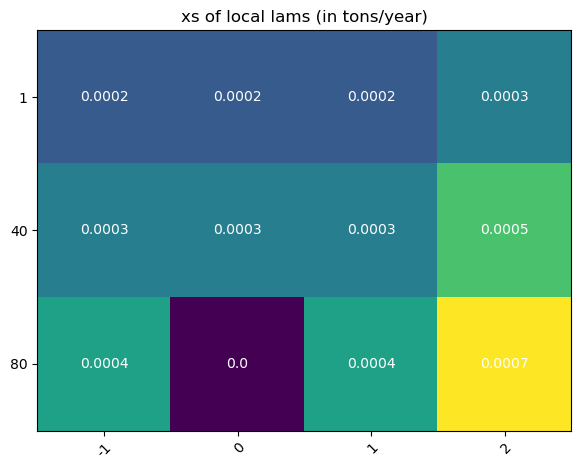

In [6]:
# Now do a scatter plot of the cross-sections 
xs = []
for idx in range(len(mass_splits)):
    tmp = []
    for lam in lams:
        tmp.append(round(variables[f"lam_{lam}_split_{mass_splits[-idx]}"][2],4))
    xs.append(tmp)

xs = np.array(xs)


fig, ax = plt.subplots()
im = ax.imshow(xs)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(lams)), labels=lams)
ax.set_yticks(np.arange(len(mass_splits)), labels=mass_splits)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(mass_splits)):
    for j in range(len(lams)):
        text = ax.text(j, i, xs[i, j],
                    ha="center", va="center", color="w")

ax.set_title("xs of local lams (in tons/year)")
fig.tight_layout()
plt.show()